In [9]:
import json
import pandas as pd
import glob
import nestpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def load_all(pathname):
    '''
    This creates a list of dataframes that are equivalent to the JSONs created with jsons.py
    ''' 
    files = glob.glob(pathname)
    #Input the pathname as wherever you have your JSONs stored.
    dfs = []
    for file in files:
        df = pd.read_json(file)
        dfs.append(df)
    return dfs

In [3]:
def field_filter(lower_field, upper_field, dataframes):
    '''
    Input numeric vales for the field values, and a list of pandas dataframes. 
    This filters out all data whose fields are not equal to or within the limits
    '''
    return_dfs = []
    for df in dataframes:
        field = df['field'][0]
        if lower_field <= field <= upper_field:
            return_dfs.append(df)
    return return_dfs

def energy_filter(lower_energy, upper_energy, dataframes):
    '''
    Input numeric vales for the field values, and a list of pandas dataframes.
    This filters out all data with recoil_energy values that are not equal to or within the limits
    '''
    return_dfs = []
    for df in dataframes:
        energies = df['recoil_energy']
        flag = True
        for e in energies:
            if lower_energy <= e <= upper_energy:
                pass
            else:
                flag = False
        if flag == True:
            return_dfs.append(df)
    return return_dfs

def interaction_type_filter(interaction, dataframes):
    '''
    Input a string for the interaction type, and a list of pandas dataframes.
    The function filters data based on interaction type.
    '''
    return_dfs = []
    for df in dataframes:
        if df['interaction_type'][0] == interaction:
            return_dfs.append(df)
    return return_dfs

In [4]:
#NEST helper functions for creating the NEST curves

detector = nestpy.DetectorExample_XENON10()     
nc = nestpy.NESTcalc(detector)
@np.vectorize
def GetYieldsVectorized(interaction, yield_type, **kwargs):
    yield_object = nc.GetYields(interaction = interaction, **kwargs)
    return getattr(yield_object, yield_type) 
def ElectronYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)
def PhotonYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)
def nest_curve(field, yield_type):
    fields = np.asarray([field])
    energies = np.logspace(-1, 2, 1000,)
    energies = np.reshape(energies, (1000,1))
    energies = np.broadcast_to(energies, (len(energies), len(fields)))
    kwargs = {'energy': energies, 'drift_field': fields}
    if yield_type == 'charge':
        nest_yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    if yield_type == 'light':
        nest_yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (energies, nest_yields)
def get_yields(energies, field, yield_type):
    kwargs = {'energy': energies, 'drift_field': field}
    if yield_type == 'charge':
        nest_yields = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    if yield_type == 'light':
        nest_yields = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
    return (nest_yields)

In [5]:
def plot_data(df, savefig=False):#, charge_or_light, nest_values, savefig=False):
    '''
    Goal: to make a scatter plot of all the different yields at various energies.
    '''
    #Uncomment these two lines if you want to include a textbox with the nestpy version:
    #version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
   # bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')
    
    #Create the plot
    fig, (subplot1, subplot2) = plt.subplots(2, figsize=(7,5), gridspec_kw={'height_ratios': [3, 1]})
     
    #Get data from the dataframe
    yields = df['yield'].tolist()
    energy = df['corrected_energy'].tolist()
    driftField = df['field'].iloc[0]
    yieldType = df['yield_type'].iloc[0]    
    name = df['identification'].iloc[0]
    
    subplot1.scatter(energy, yields, s=15, c= '#1f77b4',label= name)
    
    #If error information is included, create errorbars in both x and y dimensions
    try:
        subplot1.errorbar(energy, yields, xerr = df['recoil_error'].tolist(), linewidth = 1, fmt = 'none')
    except:
        pass
    try:
        yield_errors = [df['min_yield'].tolist(), df['max_yield'].tolist()]
        subplot1.errorbar(energy, yields, yerr = yield_errors, linewidth = 1, fmt = 'none')
    except:
        pass
        
    #plotting the nest curve
    nest_label = ['NEST: ', driftField, ' V/cm']
    nest_label = ''.join(str(v) for v in nest_label)
    curve = nest_curve(driftField, yieldType)
    subplot1.plot(curve[0], curve[1], 'c--', label= nest_label)
    
    #Limit the range of the plot, for readability
    max_x, min_x, max_y, min_y = max(energy), min(energy), max(yields), min(yields)
    subplot1.set_xlim([min_x - 5, max_x + 5])
    subplot1.set_ylim([min_y - .5, max_y + .5])
    
    #Add labels and a legend
    subplot1.legend(loc='upper left') 
    subplot1.legend(prop={'size': 9})
    subplot1.set_xlabel('Recoil Energy [keV]')
    if yieldType == 'charge':
        subplot1.set_ylabel('Charge Yield [e-/keVr]') 
    else:
        subplot1.set_ylabel('Light Yield [ph/keVr]')   
   
    #Creating a subplot with residuals: 
    nest_yvals = get_yields(energy, driftField, yieldType)
    residuals = {}
    for i in range(len(energy)):
        residuals[energy[i]] = (yields[i]-nest_yvals[i])
    try:
        error_div = [(a + b)/2 for a, b in zip(yield_errors[0], yield_errors[1])]
        residuals[energy[i]] = residuals[energy[i]] / error_div[i]
    except:
        pass    
    subplot2.scatter(list(residuals.keys()), list(residuals.values()))#, 'c--', label= nest_label)
    
    #Labels and a line at 0 for the residuals subplot
    subplot2.axhline(y=0, ls= '--')
    subplot2.set_ylabel('\u03C3 (deviation)')
    
    #Grid lines
    subplot1.grid(b=True)
    subplot2.grid(b=True)
    
    plt.tight_layout()
    
    if savefig: 
        plt.savefig('qy.png') 

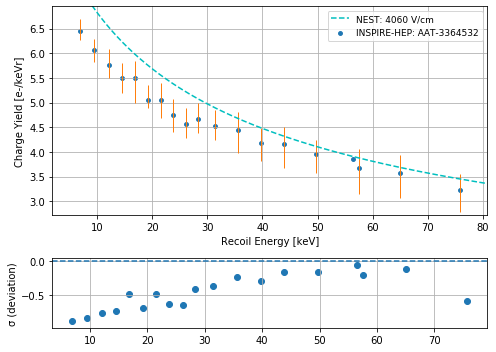

In [8]:
plot_data(afile)
#plot_data(bfile)

/opt/conda/envs/strax-dev/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/conda/envs/strax-dev/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/opt/conda/envs/strax-dev/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed a

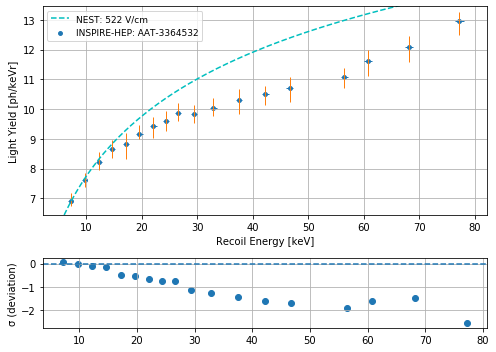

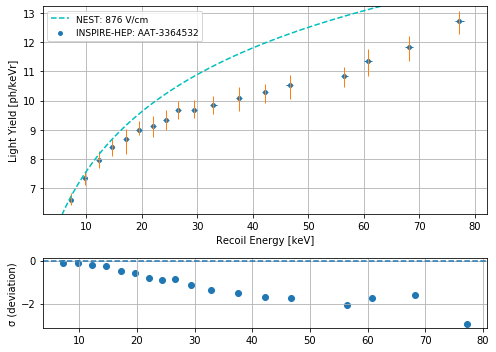

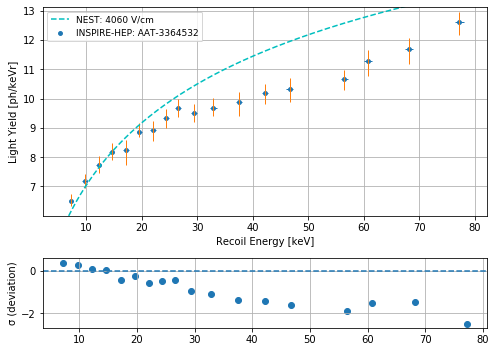

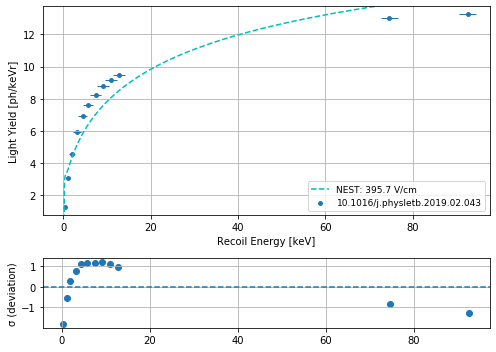

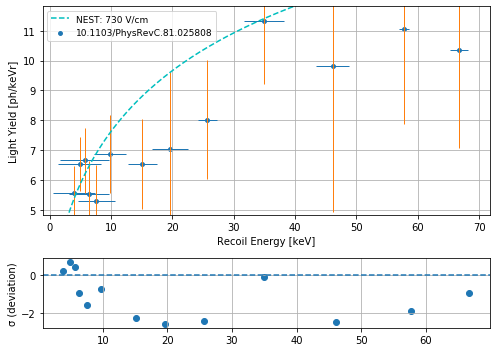

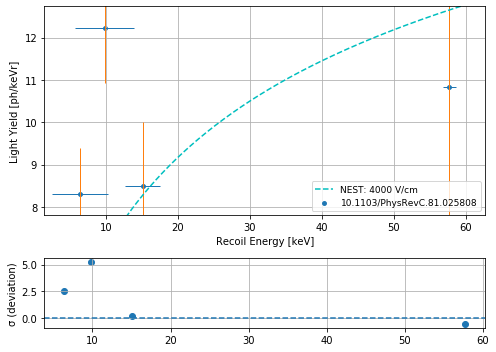

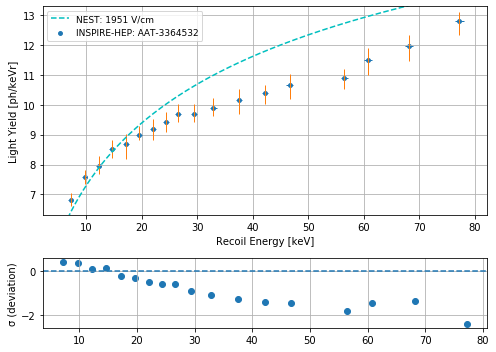

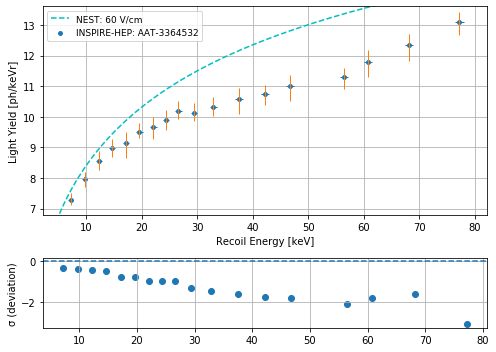

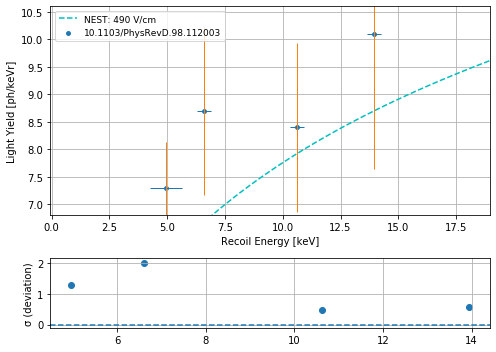

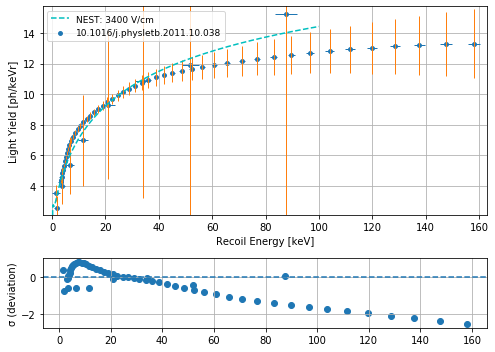

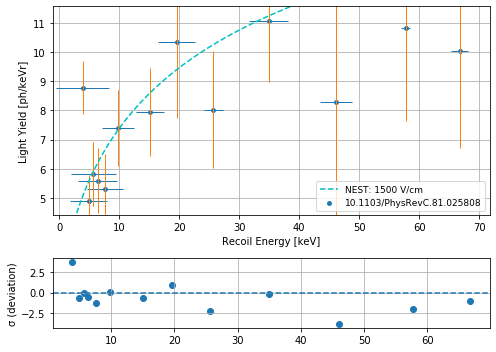

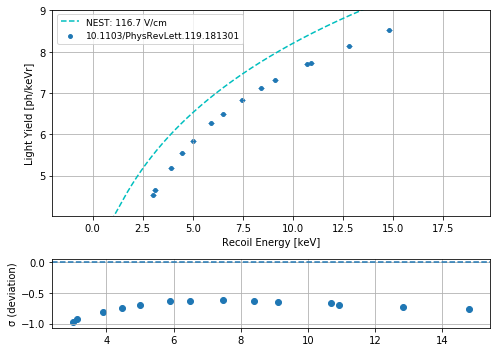

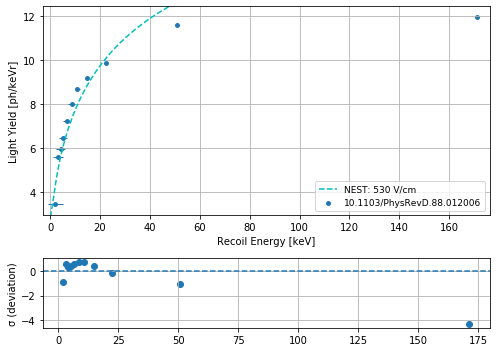

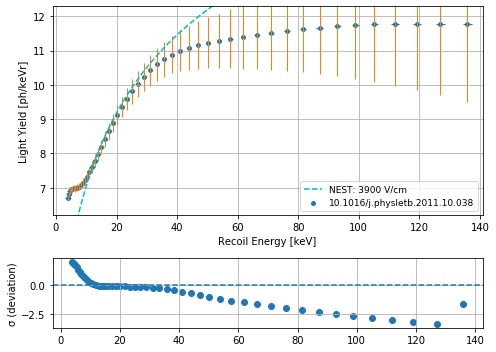

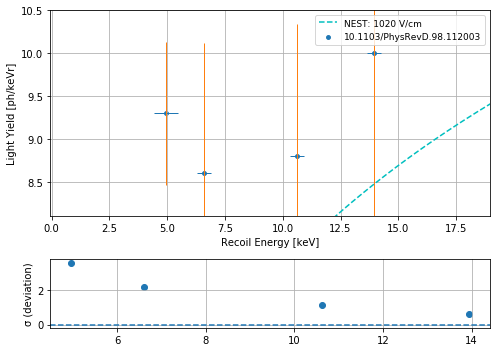

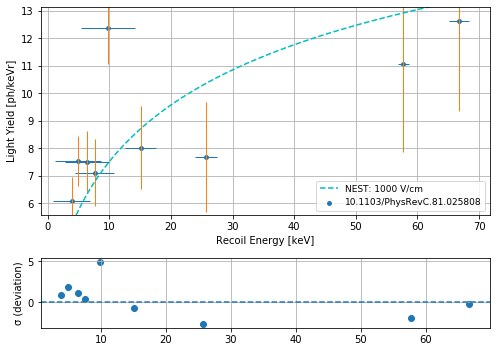

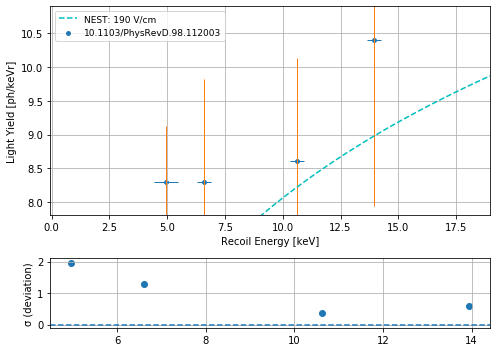

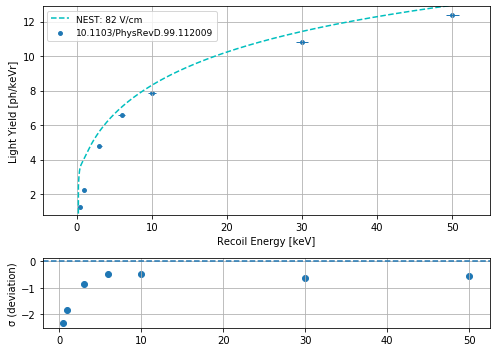

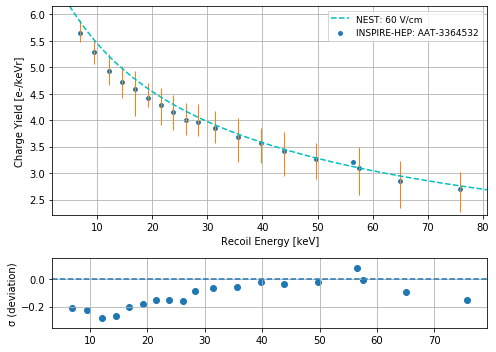

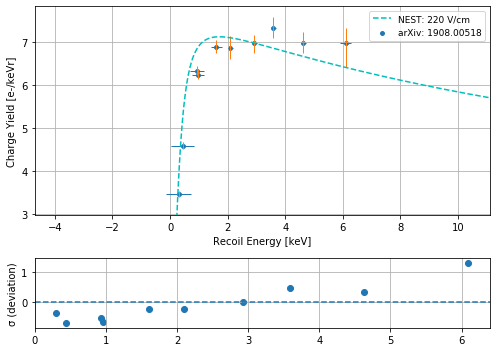

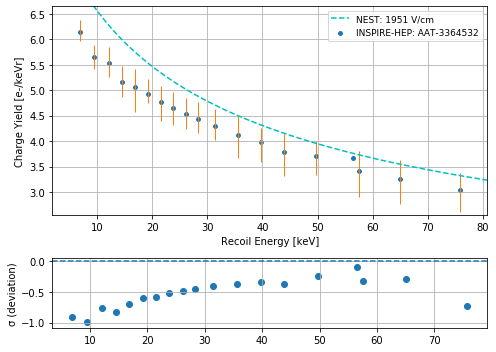

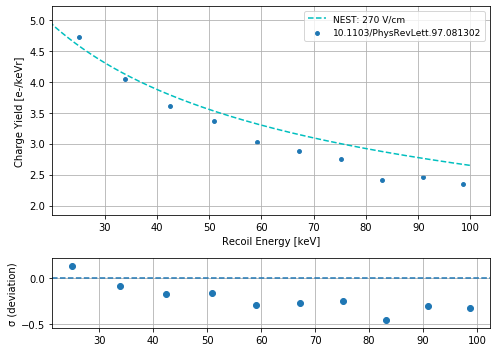

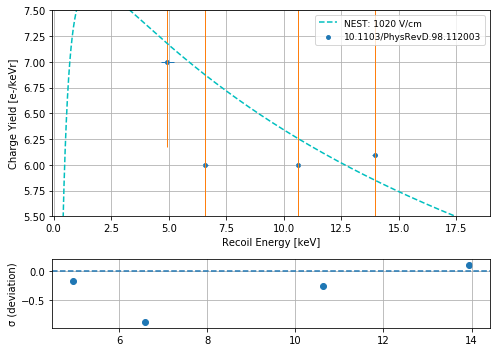

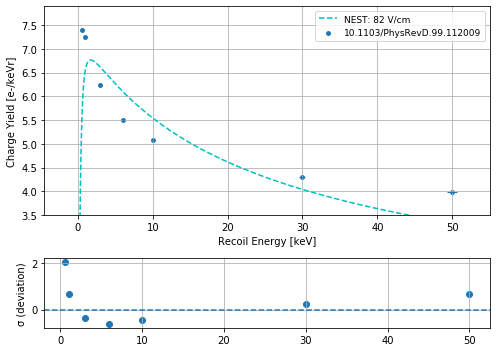

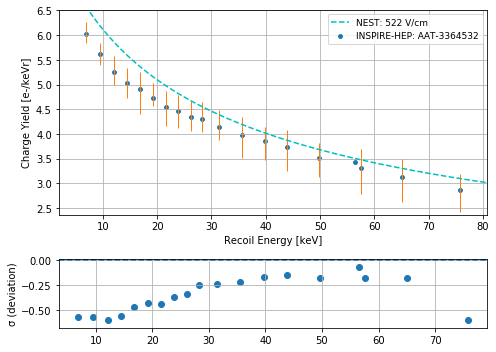

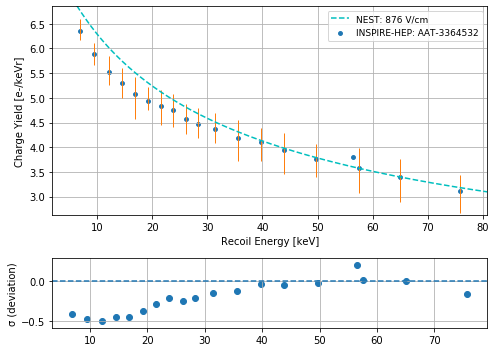

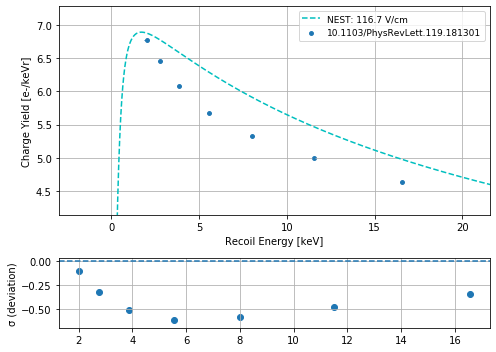

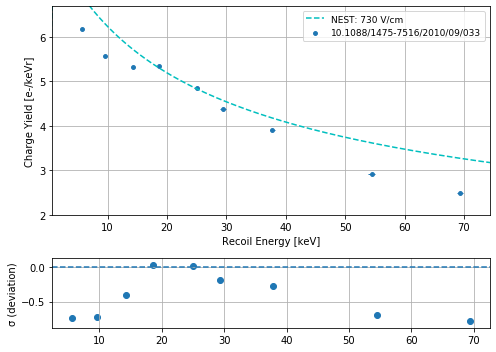

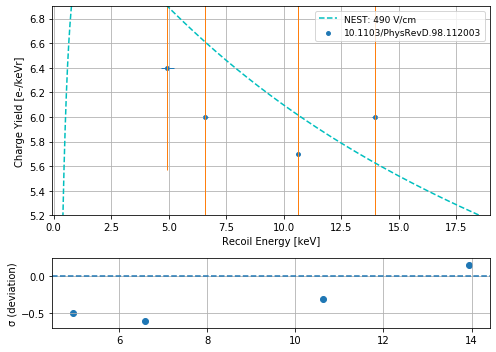

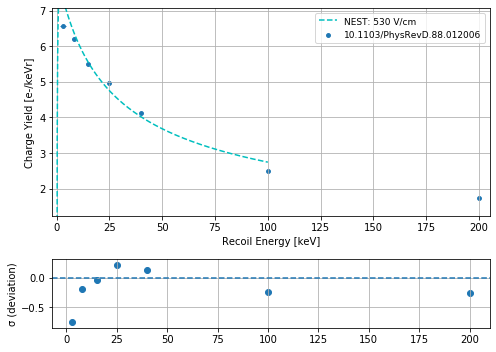

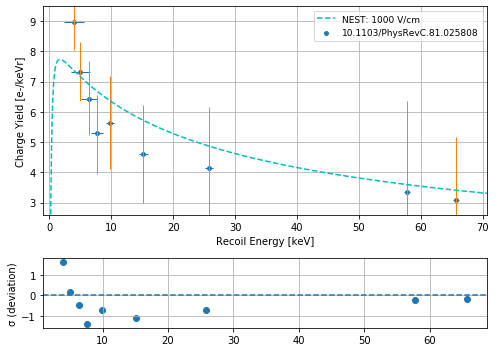

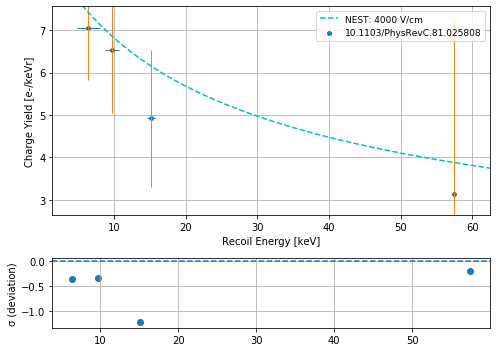

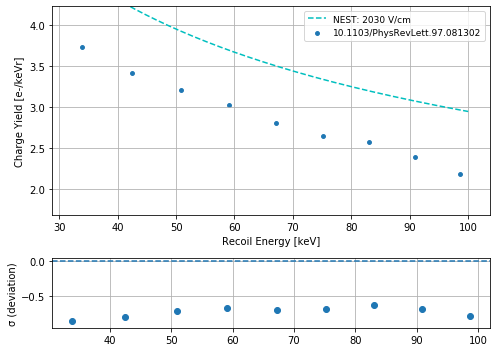

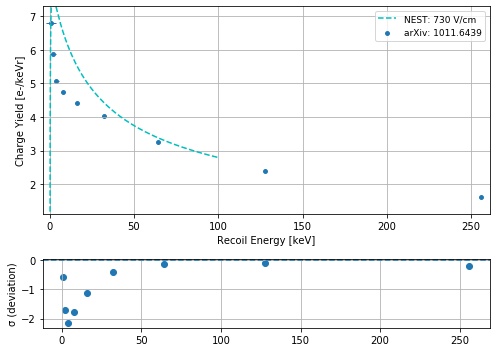

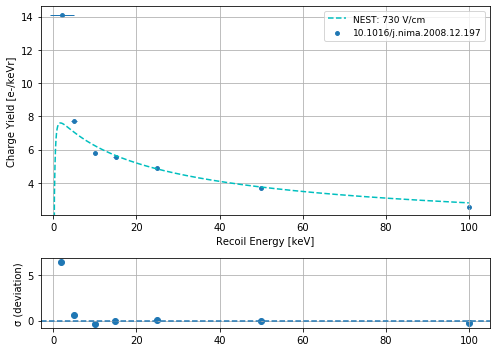

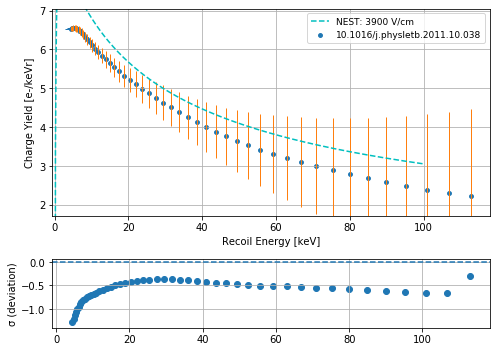

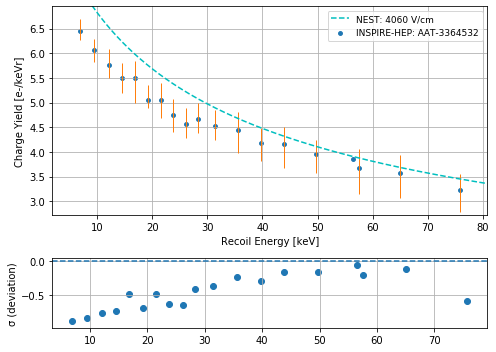

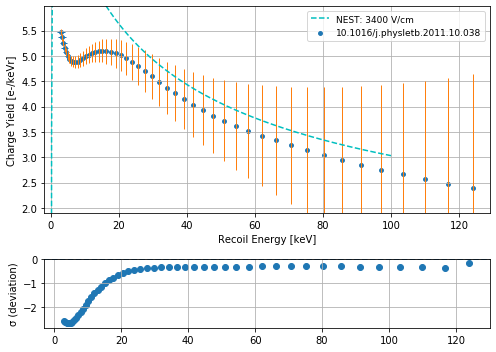

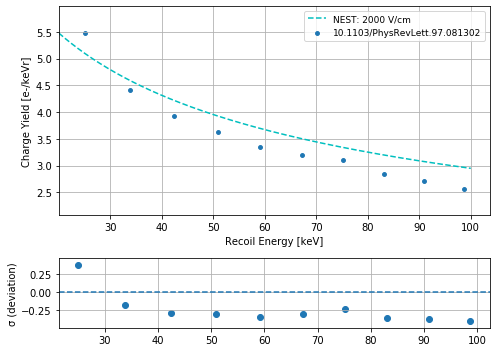

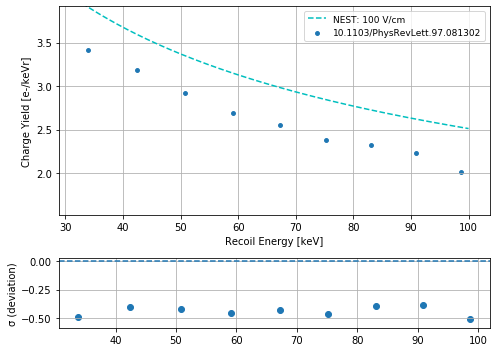

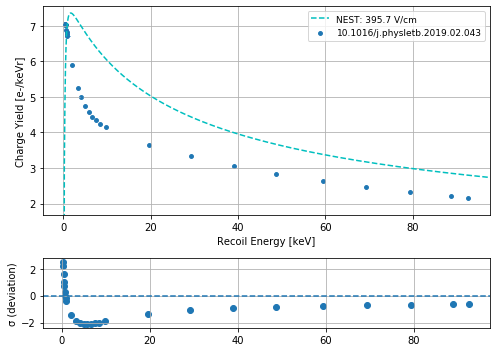

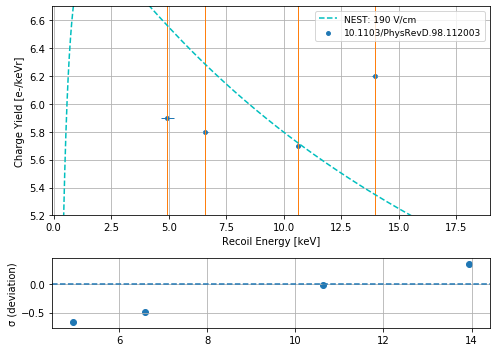

In [73]:
def make_pdf(dfs, filename):
    '''Given a list of dataframes, create a pdf with the given filename containing a plot of each one'''
    pdf = matplotlib.backends.backend_pdf.PdfPages(filename)
    for df in dfs:
        fig = plot_data(df)
        pdf.savefig(fig)
    pdf.close()